In [22]:
%conda info


     active environment : deeplearning37
    active env location : /opt/conda/envs/deeplearning37
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.9.2
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.conda/pkgs
       envs directories : /opt/conda/envs
                          /opt/ml/.conda/envs
               platform : linux-64

# Dataset and Dataloader

In [23]:
import os
from pathlib import Path

BASE_DIR = Path('.').resolve().parent
BASE_DIR

PosixPath('/opt/ml')

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [39]:
from tqdm import tqdm

In [26]:
import random
random.seed(123)

In [27]:
import warnings
warnings.filterwarnings('ignore')

## Custom Dataset

In [28]:
df_path = BASE_DIR / 'output' / 'all_df.pkl'
df = pd.read_pickle(df_path)
df.head()

,id,gender,race,age,path,filepath,filename,mask_type,age_category,category,cat_code,gender_code,mask_code
4,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,incorrect_mask.jpg,incorrect,middle,"(female, middle, incorrect)",0,0,0
3,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask1.jpg,mask,middle,"(female, middle, mask)",1,0,1
6,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask2.jpg,mask,middle,"(female, middle, mask)",1,0,1
2,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask3.jpg,mask,middle,"(female, middle, mask)",1,0,1
0,000001,female,Asian,45,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,mask4.jpg,mask,middle,"(female, middle, mask)",1,0,1


In [29]:
idx = 3

row = df.iloc[idx, :]
img_name = row['path'] + row['filename']
img_path = row['filepath']
img_np = mpimg.imread(img_path)

In [30]:
img_np.shape

(512, 384, 3)

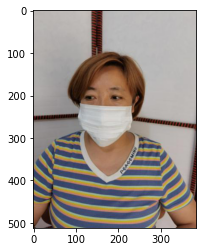

In [31]:
plt.imshow(img_np)

In [32]:
class MaskDataset(Dataset):
    def __init__(self, pkl_path, transform=None, target_transform=None):
        self.df = pd.read_pickle(pkl_path)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx, :]
        img_name = row['path'] + row['filename']
        img_path = row['filepath']
        img_np = mpimg.imread(img_path) # H, W, C
        
        label_gender = row['gender_code'] # TODO: 미리 category 숫자로 바꿔놓아야 한다. 
        label_age = row['age']
        label_mask = row['mask_code']
        label_cat = row['cat_code']
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            pass
        
        sample = {'image': img_np, 'gender': label_gender, 'age': label_age, 'mask': label_mask, 'label': label_cat}
#         sample = {'image': img_np, 'label': label_cat}
        
        return sample

In [33]:
mask_dataset = MaskDataset(pkl_path=df_path,)
len(mask_dataset)

18900

gender: 0, age: 58, mask: 1


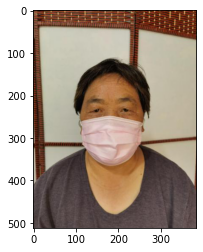

In [40]:
sample_idx = 60
sample_data = mask_dataset[sample_idx]

sample_img = sample_data['image']

plt.imshow(sample_img)
print(f"gender: {sample_data['gender']}, age: {sample_data['age']}, mask: {sample_data['mask']}")

In [41]:
sample_img.shape

(512, 384, 3)

### Define Transformations

`Albumentations` 라이브러리를 이용해 transformation을 정의해준다. 

In [55]:
transform = A.Compose([
    A.RandomCrop(width=200, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(), # 넣으면 plot 이상해짐
#     ToTensorV2(), # 넣으면 plot 안됨. 
])

In [56]:
sample_trsfm = transform(image=sample_img)
sample_trsfm_img = sample_trsfm['image']
sample_trsfm_img.shape

(300, 200, 3)

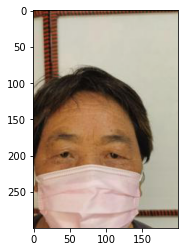

In [57]:
plt.imshow(sample_trsfm_img)

## DataLoader

batch, shuffle, multiprocessing을 모두 지원할 수 있는 `DataLoader`를 써서 완성한다. 

In [58]:
transform = A.Compose([
    A.RandomCrop(width=200, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(), 
])

transformed_dataset = MaskDataset(pkl_path=df_path, transform=transform)

In [59]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=10)
dataloader